- Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm 

In [2]:
class NeuralNetwork:
    def __init__(self, N, A, activation, activation_grad, weight_init, num_epochs, batch_size, lr=0.01, early_stopping=False, patience=5):
        self.N = N
        self.A = A
        self.lr = lr
        self.activation = activation
        self.activation_grad = activation_grad
        self.weight_init = weight_init
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.patience = patience
        self.weights = []
        self.biases = []
        self.activations = []
        self.train_loss = []  # Store training loss for each epoch
        self.val_loss = []    # Store validation loss for each epoch

    def forward_propagation(self, X):
        self.activations[0] = X
        for i in range(self.N - 1):
            X_temp = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            X_activated = Softmax.compute(X_temp) if i == self.N - 2 else self.activation(X_temp)
            self.activations[i + 1] = X_activated
        return X_activated

    def backward_propagation(self, X, y, output):
        error = (output - y) / X.shape[0]

        for i in range(self.N - 2, -1, -1):
            d_weights = np.dot(self.activations[i].T, error)
            d_biases = np.sum(error, axis=0, keepdims=True)

            max_grad = 15.0
            d_weights = np.clip(d_weights, -max_grad, max_grad)
            d_biases = np.clip(d_biases, -max_grad, max_grad)

            self.weights[i] -= self.lr * d_weights
            self.biases[i] -= self.lr * d_biases

            if i > 0:
                error = np.dot(error, self.weights[i].T) * self.activation_grad(self.activations[i])

    def fit(self, X, y, X_val, y_val):
        input_dim = X.shape[1]
        output_dim = y.shape[1]
        self.A.insert(0, input_dim)
        self.A.append(output_dim)

        self.N = len(self.A)

        for i in range(len(self.A) - 1):
            self.weights.append(self.weight_init((self.A[i], self.A[i + 1])))
            self.biases.append(self.weight_init((1, self.A[i + 1])))

        self.activations = [np.zeros((X.shape[0], self.A[i])) for i in range(self.N)]

        best_val_loss = float('inf')  # Set a high initial best validation loss
        epochs_since_improvement = 0  # Counter for epochs since last improvement

        for epoch in range(self.num_epochs):
            for i in range(0, X.shape[0], self.batch_size):
                X_batch = X[i:min(i + self.batch_size, X.shape[0])]
                y_batch = y[i:min(i + self.batch_size, y.shape[0])]

                y_pred = self.forward_propagation(X_batch)
                self.backward_propagation(X_batch, y_batch, y_pred)

            # Calculate training loss
            y_pred_train = self.forward_propagation(X)
            training_loss = -np.sum(y * np.log(y_pred_train + 1e-8)) / y.shape[0]

            # Calculate validation loss
            y_pred_val = self.forward_propagation(X_val)
            validation_loss = -np.sum(y_val * np.log(y_pred_val + 1e-8)) / y_val.shape[0]

            self.train_loss.append(training_loss)  # Save training loss
            self.val_loss.append(validation_loss)  # Save validation loss

            print(f"Epoch: {epoch + 1} | Training loss: {training_loss} | Validation loss: {validation_loss}")

            # Early stopping: Check if the validation loss improved
            if self.early_stopping:
                if validation_loss < best_val_loss:
                    best_val_loss = validation_loss
                    epochs_since_improvement = 0  # Reset the counter if validation loss improves
                else:
                    epochs_since_improvement += 1

                # If we have reached the patience limit, stop training early
                if epochs_since_improvement >= self.patience:
                    print(f"Early stopping triggered after epoch {epoch + 1}")
                    break

        return self.train_loss, self.val_loss


    def predict_proba(self, X):


        return self.forward_propagation(X)

    def predict(self, X):

        y_pred_proba = self.predict_proba(X)

        y_pred = np.zeros_like(y_pred_proba)
        y_pred[np.arange(len(y_pred_proba)), y_pred_proba.argmax(1)] = 1

        return y_pred

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

In [3]:
class Activation:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def sigmoid_grad(x):
        return Activation.sigmoid(x) * (1 - Activation.sigmoid(x))

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_grad(x):
        return np.where(x > 0, 1, 0)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def tanh_grad(x):
        return 1 - np.tanh(x)**2

    @staticmethod
    def leaky_relu(x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)

    @staticmethod
    def leaky_relu_grad(x, alpha=0.01):
        return np.where(x > 0, 1, alpha)

In [4]:
class Softmax:
    @staticmethod
    def compute(x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

In [5]:
class WeightInitializer:
    @staticmethod
    def zero_init(shape):
        return np.zeros(shape)

    @staticmethod
    def random_init(shape):
        return np.random.rand(*shape) * 2 - 1 / np.sqrt(np.prod(shape))

    @staticmethod
    def normal_init(shape):
        return np.random.normal(0, 1, shape) / np.sqrt(np.prod(shape))

In [6]:
def load_images(file_path):
    with open(file_path, 'rb') as f:
        f.read(16)  
        images = np.fromfile(f, dtype=np.uint8)
        images = images.reshape(-1, 28, 28)
    return images

In [7]:
def load_labels(file_path):
    with open(file_path, 'rb') as f:
        f.read(8)  
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

In [8]:
X_train_full = load_images('Dataset/train-images.idx3-ubyte')
y_train_full = load_labels('Dataset/train-labels.idx1-ubyte')

In [9]:
X_train_full = X_train_full.reshape(X_train_full.shape[0], -1)
X_train_full = X_train_full / 255.0

In [10]:
np.random.seed(42)
indices = np.random.permutation(X_train_full.shape[0])


In [11]:
train_size = int(0.8 * X_train_full.shape[0])
val_size = int(0.1 * X_train_full.shape[0])
test_size=int(0.1 * X_train_full.shape[0])

In [12]:
X_train = X_train_full[indices[:train_size]]
y_train = y_train_full[indices[:train_size]]
X_val = X_train_full[indices[train_size:train_size + val_size]]
y_val = y_train_full[indices[train_size:train_size + val_size]]
X_test = X_train_full[indices[train_size:train_size + val_size]]
y_test = y_train_full[indices[train_size:train_size + val_size]]

In [13]:
num_epochs = 10
batch_size = 64
learning_rate = 2e-3
hidden_layer_sizes = [256, 128, 64, 32]
activation_functions = [Activation.relu, Activation.sigmoid, Activation.tanh, Activation.leaky_relu]
activation_gradients = [Activation.relu_grad, Activation.sigmoid_grad, Activation.tanh_grad, Activation.leaky_relu_grad]
weight_initializations = [WeightInitializer.zero_init, WeightInitializer.random_init, WeightInitializer.normal_init]
layer_sizes = [784] + hidden_layer_sizes + [10]

In [14]:
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

In [15]:
y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

In [16]:
train_losses = {}
val_losses = {}

Epoch: 1 | Training loss: 2.3022328237335694 | Validation loss: 2.302108935862344
Epoch: 2 | Training loss: 2.3019724087038793 | Validation loss: 2.3017420872466
Epoch: 3 | Training loss: 2.301780063941039 | Validation loss: 2.301458452986432
Epoch: 4 | Training loss: 2.30163813468169 | Validation loss: 2.3012383330440307
Epoch: 5 | Training loss: 2.30153349104113 | Validation loss: 2.30106679806218
Epoch: 6 | Training loss: 2.3014563887162005 | Validation loss: 2.30093252897706
Epoch: 7 | Training loss: 2.301399609252282 | Validation loss: 2.300826935515766
Epoch: 8 | Training loss: 2.3013578136913186 | Validation loss: 2.3007434883442035
Epoch: 9 | Training loss: 2.301327058379533 | Validation loss: 2.3006772142987018
Epoch: 10 | Training loss: 2.3013044334427746 | Validation loss: 2.30062431562644


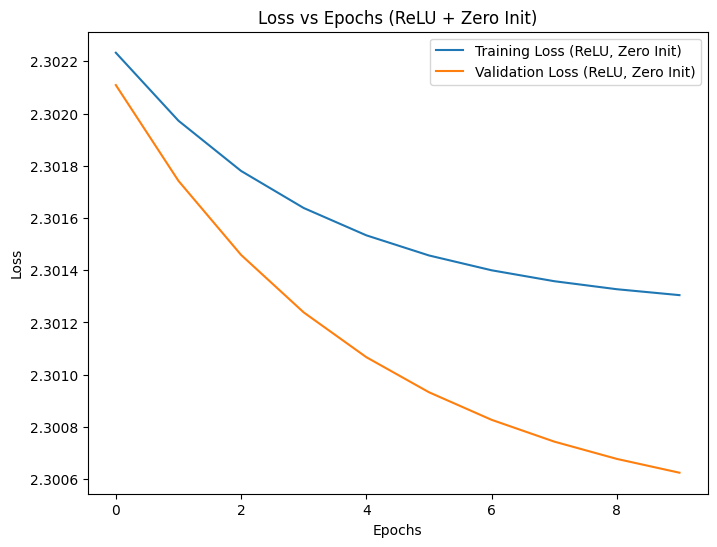

In [17]:

activation = Activation.relu
activation_grad = Activation.relu_grad
weight_init = WeightInitializer.zero_init

nn_1 = NeuralNetwork(
    N=len(layer_sizes), 
    A=layer_sizes,       
    activation=activation,  
    activation_grad=activation_grad,  
    weight_init=weight_init,  
    num_epochs=10,  
    batch_size=64, 
    lr=2e-3,        
    early_stopping=True,  
    patience=5     
)

train_loss_1, val_loss_1 = nn_1.fit(X_train, y_train, X_val, y_val)

plt.figure(figsize=(8, 6))
plt.plot(range(len(train_loss_1)), train_loss_1, label="Training Loss (ReLU, Zero Init)")
plt.plot(range(len(val_loss_1)), val_loss_1, label="Validation Loss (ReLU, Zero Init)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (ReLU + Zero Init)')
plt.legend()
plt.show()

with open("ReLU_Zero_Init_model.pkl", "wb") as f:
    pickle.dump(nn_1, f)


Epoch: 1 | Training loss: 16.74938772971357 | Validation loss: 16.775099929932622
Epoch: 2 | Training loss: 16.61276768078842 | Validation loss: 16.584752895475116
Epoch: 3 | Training loss: 16.51490781428305 | Validation loss: 16.618524143524027
Epoch: 4 | Training loss: 16.600870991134826 | Validation loss: 16.495719605164346
Epoch: 5 | Training loss: 16.637328588460356 | Validation loss: 16.643085051195964
Epoch: 6 | Training loss: 16.61583779424741 | Validation loss: 16.716767774211775
Epoch: 7 | Training loss: 16.600870991134826 | Validation loss: 16.495719605164346
Epoch: 8 | Training loss: 16.36562354733956 | Validation loss: 16.23168984769103
Epoch: 9 | Training loss: 16.600870991134826 | Validation loss: 16.495719605164346
Epoch: 10 | Training loss: 16.61276768078842 | Validation loss: 16.584752895475116


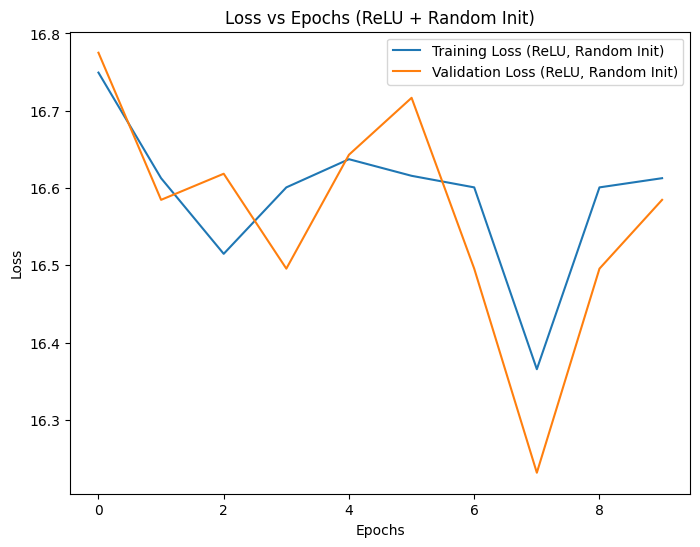

In [18]:

weight_init = WeightInitializer.random_init

nn_2 = NeuralNetwork(
    N=len(layer_sizes), 
    A=layer_sizes,      
    activation=activation, 
    activation_grad=activation_grad,  
    weight_init=weight_init, 
    num_epochs=10, 
    batch_size=64, 
    lr=2e-3,        
    early_stopping=True,  
    patience=5      
)

train_loss_2, val_loss_2 = nn_2.fit(X_train, y_train, X_val, y_val)

plt.figure(figsize=(8, 6))
plt.plot(range(len(train_loss_2)), train_loss_2, label="Training Loss (ReLU, Random Init)")
plt.plot(range(len(val_loss_2)), val_loss_2, label="Validation Loss (ReLU, Random Init)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (ReLU + Random Init)')
plt.legend()
plt.show()

with open("ReLU_Random_Init_model.pkl", "wb") as f:
    pickle.dump(nn_2, f)


In [ ]:

weight_init = WeightInitializer.normal_init

nn_3 = NeuralNetwork(
    N=len(layer_sizes), 
    A=layer_sizes,      
    activation=activation,  
    activation_grad=activation_grad,  
    weight_init=weight_init,  
    num_epochs=10,  
    batch_size=64,  
    lr=2e-3,        
    early_stopping=True,  
    patience=5     
)

train_loss_3, val_loss_3 = nn_3.fit(X_train, y_train, X_val, y_val)

plt.figure(figsize=(8, 6))
plt.plot(range(len(train_loss_3)), train_loss_3, label="Training Loss (ReLU, Normal Init)")
plt.plot(range(len(val_loss_3)), val_loss_3, label="Validation Loss (ReLU, Normal Init)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (ReLU + Normal Init)')
plt.legend()
plt.show()

with open("ReLU_Normal_Init_model.pkl", "wb") as f:
    pickle.dump(nn_3, f)


Epoch: 1 | Training loss: 2.3291440971867177 | Validation loss: 2.324891127706691
Epoch: 2 | Training loss: 2.3151675772244733 | Validation loss: 2.3120566200885384
Epoch: 3 | Training loss: 2.308167911245861 | Validation loss: 2.305817768163455
Epoch: 4 | Training loss: 2.304652582973157 | Validation loss: 2.3028135160385226
Epoch: 5 | Training loss: 2.302902807388261 | Validation loss: 2.30140610083204
Epoch: 6 | Training loss: 2.3020441334832675 | Validation loss: 2.3007747149170656
Epoch: 7 | Training loss: 2.301627620880835 | Validation loss: 2.30050770013102


In [ ]:

weight_init = WeightInitializer.random_init

nn_5 = NeuralNetwork(
    N=len(layer_sizes), 
    A=layer_sizes,       
    activation=activation,  
    activation_grad=activation_grad, 
    weight_init=weight_init, 
    num_epochs=10,  
    batch_size=64, 
    lr=2e-3,       
    early_stopping=True,  
    patience=5      
)

train_loss_5, val_loss_5 = nn_5.fit(X_train, y_train, X_val, y_val)

plt.figure(figsize=(8, 6))
plt.plot(range(len(train_loss_5)), train_loss_5, label="Training Loss (Sigmoid, Random Init)")
plt.plot(range(len(val_loss_5)), val_loss_5, label="Validation Loss (Sigmoid, Random Init)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (Sigmoid + Random Init)')
plt.legend()
plt.show()

with open("Sigmoid_Random_Init_model.pkl", "wb") as f:
    pickle.dump(nn_5, f)


In [ ]:

weight_init = WeightInitializer.normal_init

nn_6 = NeuralNetwork(
    N=len(layer_sizes), 
    A=layer_sizes,      
    activation=activation,  
    activation_grad=activation_grad, 
    weight_init=weight_init,  
    num_epochs=10,  
    batch_size=64,  
    lr=2e-3,        
    early_stopping=True,  
    patience=5     
)

train_loss_6, val_loss_6 = nn_6.fit(X_train, y_train, X_val, y_val)

plt.figure(figsize=(8, 6))
plt.plot(range(len(train_loss_6)), train_loss_6, label="Training Loss (Sigmoid, Normal Init)")
plt.plot(range(len(val_loss_6)), val_loss_6, label="Validation Loss (Sigmoid, Normal Init)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (Sigmoid + Normal Init)')
plt.legend()
plt.show()

with open("Sigmoid_Normal_Init_model.pkl", "wb") as f:
    pickle.dump(nn_6, f)


In [ ]:

activation = Activation.tanh
activation_grad = Activation.tanh_grad
weight_init = WeightInitializer.zero_init

nn_7 = NeuralNetwork(
    N=len(layer_sizes),  
    A=layer_sizes,       
    activation=activation, 
    activation_grad=activation_grad, 
    weight_init=weight_init, 
    num_epochs=10, 
    batch_size=64, 
    lr=2e-3,       
    early_stopping=True, 
    patience=5     
)

train_loss_7, val_loss_7 = nn_7.fit(X_train, y_train, X_val, y_val)

plt.figure(figsize=(8, 6))
plt.plot(range(len(train_loss_7)), train_loss_7, label="Training Loss (Tanh, Zero Init)")
plt.plot(range(len(val_loss_7)), val_loss_7, label="Validation Loss (Tanh, Zero Init)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (Tanh + Zero Init)')
plt.legend()
plt.show()

with open("Tanh_Zero_Init_model.pkl", "wb") as f:
    pickle.dump(nn_7, f)


In [ ]:

weight_init = WeightInitializer.random_init

nn_8 = NeuralNetwork(
    N=len(layer_sizes),  
    A=layer_sizes,       
    activation=activation,  
    activation_grad=activation_grad,  
    weight_init=weight_init,  
    num_epochs=10,  
    batch_size=64,  
    lr=2e-3,        
    early_stopping=True,
    patience=5     
)

train_loss_8, val_loss_8 = nn_8.fit(X_train, y_train, X_val, y_val)

plt.figure(figsize=(8, 6))
plt.plot(range(len(train_loss_8)), train_loss_8, label="Training Loss (Tanh, Random Init)")
plt.plot(range(len(val_loss_8)), val_loss_8, label="Validation Loss (Tanh, Random Init)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (Tanh + Random Init)')
plt.legend()
plt.show()

with open("Tanh_Random_Init_model.pkl", "wb") as f:
    pickle.dump(nn_8, f)


In [ ]:

weight_init = WeightInitializer.normal_init

nn_9 = NeuralNetwork(
    N=len(layer_sizes),  
    A=layer_sizes,       
    activation=activation,  
    activation_grad=activation_grad,  
    weight_init=weight_init, 
    num_epochs=10,  
    batch_size=64, 
    lr=2e-3,       
    early_stopping=True,  
    patience=5      
)

train_loss_9, val_loss_9 = nn_9.fit(X_train, y_train, X_val, y_val)

plt.figure(figsize=(8, 6))
plt.plot(range(len(train_loss_9)), train_loss_9, label="Training Loss (Tanh, Normal Init)")
plt.plot(range(len(val_loss_9)), val_loss_9, label="Validation Loss (Tanh, Normal Init)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (Tanh + Normal Init)')
plt.legend()
plt.show()

with open("Tanh_Normal_Init_model.pkl", "wb") as f:
    pickle.dump(nn_9, f)


In [ ]:

activation = Activation.leaky_relu
activation_grad = Activation.leaky_relu_grad
weight_init = WeightInitializer.zero_init

nn_10 = NeuralNetwork(
    N=len(layer_sizes),  
    A=layer_sizes,      
    activation=activation,  
    activation_grad=activation_grad, 
    weight_init=weight_init, 
    num_epochs=10, 
    batch_size=64, 
    lr=2e-3,       
    early_stopping=True,  
    patience=5     
)

train_loss_10, val_loss_10 = nn_10.fit(X_train, y_train, X_val, y_val)

plt.figure(figsize=(8, 6))
plt.plot(range(len(train_loss_10)), train_loss_10, label="Training Loss (Leaky ReLU, Zero Init)")
plt.plot(range(len(val_loss_10)), val_loss_10, label="Validation Loss (Leaky ReLU, Zero Init)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (Leaky ReLU + Zero Init)')
plt.legend()
plt.show()

with open("Leaky_ReLU_Zero_Init_model.pkl", "wb") as f:
    pickle.dump(nn_10, f)


In [ ]:

weight_init = WeightInitializer.random_init

nn_11 = NeuralNetwork(
    N=len(layer_sizes), 
    A=layer_sizes,       
    activation=activation, 
    activation_grad=activation_grad, 
    weight_init=weight_init, 
    num_epochs=10,  
    batch_size=64,  
    lr=2e-3,       
    early_stopping=True,  
    patience=5      
)

train_loss_11, val_loss_11 = nn_11.fit(X_train, y_train, X_val, y_val)

plt.figure(figsize=(8, 6))
plt.plot(range(len(train_loss_11)), train_loss_11, label="Training Loss (Leaky ReLU, Random Init)")
plt.plot(range(len(val_loss_11)), val_loss_11, label="Validation Loss (Leaky ReLU, Random Init)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (Leaky ReLU + Random Init)')
plt.legend()
plt.show()

with open("Leaky_ReLU_Random_Init_model.pkl", "wb") as f:
    pickle.dump(nn_11, f)


In [ ]:

weight_init = WeightInitializer.normal_init

nn_12 = NeuralNetwork(
    N=len(layer_sizes),  
    A=layer_sizes,       
    activation=activation, 
    activation_grad=activation_grad,  
    weight_init=weight_init,  
    num_epochs=10, 
    batch_size=64,  
    lr=2e-3,        
    early_stopping=True,  
    patience=5      
)

train_loss_12, val_loss_12 = nn_12.fit(X_train, y_train, X_val, y_val)

plt.figure(figsize=(8, 6))
plt.plot(range(len(train_loss_12)), train_loss_12, label="Training Loss (Leaky ReLU, Normal Init)")
plt.plot(range(len(val_loss_12)), val_loss_12, label="Validation Loss (Leaky ReLU, Normal Init)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (Leaky ReLU + Normal Init)')
plt.legend()
plt.show()

with open("Leaky_ReLU_Normal_Init_model.pkl", "wb") as f:
    pickle.dump(nn_12, f)
